# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

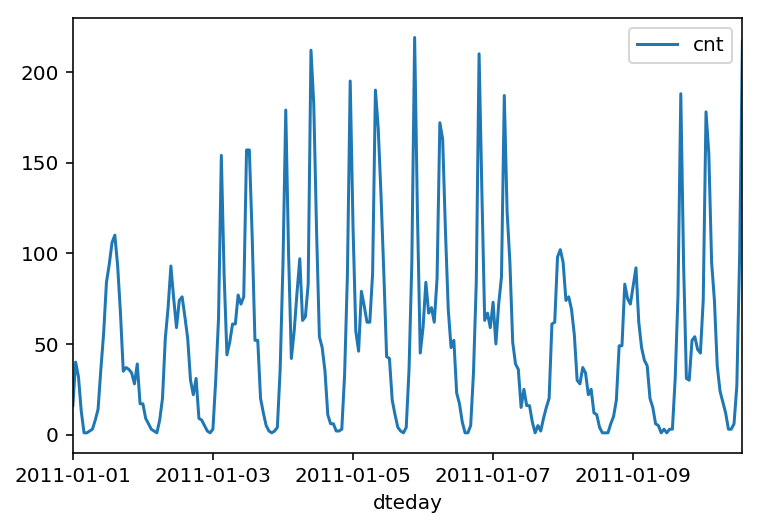

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0    ...          0      0      0          0          0          0   
1         0    ...          0      0      0          0          0          0   
2         0    ...          0      0      0          0          0          0   
3         0    ...          0      0      0          0          0          0   
4         0    ...          0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

....F

forward: X [ 0.5 -0.2  0.1]



FAIL: test_train (__main__.TestMethods)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-11-600a3355aa81>", line 48, in test_train
    [-0.29887597, 0.19962801]])))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 5 tests in 0.013s

FAILED (failures=1)


<unittest.runner.TextTestResult run=5 errors=0 failures=1>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [12]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

forward: X [1.         0.         0.32724398 1.05100987 1.13047356 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.        ]
forward: X [ 0.          0.         -1.95780412 -1.54060589  1.37405656  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.     

/Users/scrier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


forward: X [ 1.          0.          0.63884145 -0.08930106 -0.21168512  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.15817056 -1.07411506 -0.21168512  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 1.0% ... Training loss: 1.596 ... Validation loss: 2.363forward: X [ 0.          0.         -1.02301172 -0.91861811 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -1.23074336 -0.97045042 -0.21168512  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0. 

  0.          0.        ]
forward: X [ 0.          0.          1.67749968 -1.38510895 -0.69966852  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.         -0.39981678 -0.45212727  2.10644035  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.

Progress: 2.0% ... Training loss: 1.491 ... Validation loss: 2.251forward: X [ 0.          0.         -0.29595096 -0.03746875 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.          2.09296297 -1.33327663 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0. 

forward: X [ 1.          0.          0.01564651 -1.07411506  1.61845695  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.         -1.75007248 -0.19296569 -1.55384381  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.  

Progress: 3.0% ... Training loss: 1.392 ... Validation loss: 2.142forward: X [ 0.          0.          0.53497563  0.7918483  -0.69966852  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.22337816  0.74001598 -0.45608552  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0. 

forward: X [ 1.          0.         -0.71141425 -1.33327663  0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.08821931  1.62116534 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.  

Progress: 4.0% ... Training loss: 1.332 ... Validation loss: 2.073forward: X [ 0.          0.         -0.29595096  0.22169283  0.27629827  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.5036826  -1.33327663  0.51988127  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0. 

forward: X [ 0.          0.          1.36590221 -0.5557919   0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [1.         0.         0.11951233 1.62116534 0.51988127 0.
 1.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

Progress: 5.0% ... Training loss: 1.289 ... Validation loss: 2.023forward: X [0.         0.         0.95043892 0.1180282  0.03189788 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.        ]
forward: X [ 1.          0.          1.26203639 -0.91861811 -1.55384381  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.    

forward: X [ 0.          0.          0.22337816 -0.14113338  2.22823185  1.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.         -1.54234083  0.32535746 -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.  

  0.          0.        ]
forward: X [ 0.          0.          0.8465731  -0.08930106 -0.21168512  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [0.         0.         0.22337816 0.06619588 0.27629827 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0

forward: X [ 0.          0.         -1.54234083 -1.17777969 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.          0.8465731  -0.29663033  0.27629827  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.          0.22337816 -0.14113338  0.27629827  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [0.         0.         0.63884145 0.53268672 0.03189788 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0

Progress: 6.0% ... Training loss: 1.248 ... Validation loss: 1.974forward: X [ 0.          0.          0.32724398  0.27352514 -0.82146002  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.36590221 -1.54060589 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0. 

forward: X [ 1.          0.          0.63884145 -1.12594737  0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 1.          0.          1.36590221 -0.76312116 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 7.0% ... Training loss: 1.209 ... Validation loss: 1.928forward: X [ 0.          0.          0.95043892  0.84368061 -0.69966852  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.71141425  0.94734524 -1.55384381  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0. 

forward: X [ 0.          0.          1.36590221  0.37718977 -0.69966852  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.          0.63884145 -1.12594737  0.03189788  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.         -0.81528007 -0.29663033  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.         -1.02301172 -1.54060589  1.13047356  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 8.0% ... Training loss: 1.180 ... Validation loss: 1.888forward: X [ 0.          0.          0.32724398  0.27352514 -0.69966852  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          1.36590221 -1.85159979  0.27629827  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0. 

forward: X [ 0.          0.         -0.81528007 -0.71128885  2.10644035  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.         -0.9191459   0.37718977 -0.21168512  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.         -0.29595096  0.74001598 -0.21168512  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          1.         -0.60754843 -1.17777969  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 9.0% ... Training loss: 1.151 ... Validation loss: 1.850forward: X [ 0.          0.         -0.81528007  1.93215924 -0.69966852  1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 1.          0.         -0.71141425 -1.48877358  1.13047356  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0. 

  0.          0.        ]
forward: X [0.         1.         0.95043892 0.84368061 0.76428167 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.          0.63884145  0.53268672 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.   

Progress: 10.0% ... Training loss: 1.132 ... Validation loss: 1.825forward: X [ 0.          0.          0.63884145  1.31017145 -0.69966852  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.29595096 -3.2510723   0.88607317  1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          0.53497563  1.62116534 -0.45608552  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.39981678  0.22169283  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.  

Progress: 11.0% ... Training loss: 1.115 ... Validation loss: 1.801forward: X [ 1.          0.          0.8465731  -1.12594737  0.51988127  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.15817056 -0.91861811 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

  0.          0.        ]
forward: X [ 0.          0.          0.63884145  1.62116534 -0.45608552  0.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.         -0.9191459   1.56933303  0.51988127  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

Progress: 12.0% ... Training loss: 1.100 ... Validation loss: 1.781forward: X [ 0.          0.         -1.02301172  1.93215924  0.27629827  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [1.         0.         1.05430474 0.84368061 0.27629827 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

forward: X [ 0.          0.         -1.54234083 -0.81495348  0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.          1.05430474 -2.00709673  0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 13.0% ... Training loss: 1.085 ... Validation loss: 1.761forward: X [ 0.          0.          1.15817056  0.58451904 -0.45608552  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.         -0.19208513 -0.19296569  2.10644035  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          1.57363386 -0.40029496  1.13047356  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.08821931 -1.38510895  0.76428167  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

 0.         1.        ]
forward: X [ 0.          0.         -0.08821931 -1.229612    1.13047356  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.57363386 -1.74793515 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.  

Progress: 14.0% ... Training loss: 1.069 ... Validation loss: 1.739forward: X [0.         0.         0.95043892 0.84368061 0.27629827 0.
 0.         0.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.        ]
forward: X [ 1.          0.         -1.64620666  1.20650682 -0.69966852  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.   

 0.         0.        ]
forward: X [ 0.          0.         -0.29595096  1.62116534  0.51988127  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.8465731   0.58451904 -0.21168512  0.
  1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.  

Progress: 16.0% ... Training loss: 1.047 ... Validation loss: 1.709forward: X [ 0.          0.          0.95043892 -1.229612    1.37405656  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.         -0.71141425  0.42902209 -0.21168512  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          1.7813655  -0.97045042  0.76428167  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.29595096  1.93215924 -0.45608552  0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.  

Progress: 17.0% ... Training loss: 1.040 ... Validation loss: 1.700forward: X [0.         0.         1.05430474 0.1180282  0.27629827 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.        ]
forward: X [1.         0.         0.8465731  0.1180282  0.51988127 0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0

forward: X [ 1.          0.         -1.75007248 -0.81495348  2.22823185  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -1.54234083  0.89551293  2.71621524  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.  

Progress: 18.0% ... Training loss: 1.030 ... Validation loss: 1.684forward: X [ 0.          0.         -0.19208513  1.31017145 -0.82146002  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [0.         0.         0.32724398 0.06619588 0.76428167 0.
 0.         0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.  

Progress: 19.0% ... Training loss: 1.021 ... Validation loss: 1.672forward: X [ 0.          0.          0.63884145 -0.08930106  0.03189788  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [0.         0.         0.01564651 0.74001598 0.03189788 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

Progress: 20.0% ... Training loss: 1.010 ... Validation loss: 1.654forward: X [ 1.          0.          0.22337816 -0.5557919  -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [1.         0.         0.95043892 0.32535746 0.27629827 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

forward: X [ 0.          0.          0.74270727  1.36200377 -0.69966852  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.39981678 -0.24479801 -0.21168512  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 21.0% ... Training loss: 1.003 ... Validation loss: 1.643forward: X [ 1.          0.          0.63884145 -0.29663033 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.08821931 -0.19296569 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

Progress: 22.0% ... Training loss: 0.998 ... Validation loss: 1.634forward: X [ 1.          0.         -1.02301172 -1.38510895  2.47181485  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.81528007  1.25833914 -1.55384381  1.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

Progress: 23.0% ... Training loss: 0.992 ... Validation loss: 1.625forward: X [ 0.          0.          1.15817056  0.58451904 -0.69966852  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [0.         0.         0.01564651 0.01436357 0.76428167 0.
 0.         0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.  

Progress: 24.0% ... Training loss: 0.986 ... Validation loss: 1.615forward: X [ 0.          0.          0.63884145 -1.28144432  0.51988127  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -1.23074336  1.93215924  0.76428167  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.         -1.23074336 -1.12594737  0.76428167  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.          0.53497563  1.31017145 -0.69966852  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.  

  0.          0.        ]
forward: X [ 0.          0.         -1.02301172 -1.79976747  0.03189788  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [0.         0.         0.11951233 1.31017145 2.47181485 0.
 0.         0.         1.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1

forward: X [ 0.          0.          0.53497563 -0.34846264 -0.21168512  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.          0.63884145  1.31017145 -1.55384381  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 26.0% ... Training loss: 0.975 ... Validation loss: 1.596forward: X [0.         0.         0.32724398 1.05100987 1.13047356 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.        ]
forward: X [ 0.          0.          1.15817056  0.58451904 -0.45608552  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.   

forward: X [0.         0.         0.22337816 0.74001598 0.76428167 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.        ]
forward: X [ 1.          0.          1.05430474  1.10284219 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.     

forward: X [ 1.          0.         -1.43847501  0.89551293 -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.         -1.12687754 -0.08930106  0.03189788  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 27.0% ... Training loss: 0.973 ... Validation loss: 1.595forward: X [ 1.          0.          1.15817056  0.84368061 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [0.         0.         0.53497563 1.62116534 0.03189788 0.
 0.         0.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.  

forward: X [0.         0.         0.32724398 0.27352514 0.76428167 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.        ]
forward: X [ 0.          0.          1.15817056 -0.24479801 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.     

Progress: 28.0% ... Training loss: 0.969 ... Validation loss: 1.587forward: X [ 0.          0.         -1.95780412 -1.38510895  1.61845695  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.         -0.9191459  -0.71128885  4.54635732  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          0.53497563  1.77666229 -0.69966852  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.          0.74270727 -0.97045042 -0.21168512  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.  

forward: X [ 0.          0.         -0.9191459   0.16986051 -0.82146002  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.         -0.19208513 -1.12594737  0.76428167  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 29.0% ... Training loss: 0.966 ... Validation loss: 1.582forward: X [1.         0.         0.22337816 0.74001598 0.03189788 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.        ]
forward: X [ 0.          0.         -0.19208513 -0.60762422 -0.21168512  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

  0.          0.        ]
forward: X [ 0.          0.         -0.39981678  0.74001598 -0.82146002  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [1.         0.         0.32724398 1.31017145 0.76428167 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0

forward: X [ 0.          0.          0.95043892  0.32535746 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.08821931  0.01436357 -1.55384381  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.  

Progress: 31.0% ... Training loss: 0.959 ... Validation loss: 1.570forward: X [ 0.          0.          1.05430474 -1.07411506 -0.21168512  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          1.          0.11951233 -0.40029496  0.76428167  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

Progress: 32.0% ... Training loss: 0.956 ... Validation loss: 1.565forward: X [ 1.          0.          0.95043892 -0.97045042 -0.21168512  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [0.         0.         0.4311098  0.7918483  0.03189788 0.
 0.         0.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.  

forward: X [ 0.          0.         -1.23074336 -0.14113338  0.76428167  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.          1.26203639 -1.17777969 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 33.0% ... Training loss: 0.952 ... Validation loss: 1.558forward: X [ 0.          0.          1.7813655  -0.71128885 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.          1.7813655  -0.34846264  0.76428167  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.          0.74270727 -1.28144432  0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.         -0.81528007 -1.229612    1.37405656  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 34.0% ... Training loss: 0.950 ... Validation loss: 1.554forward: X [ 1.          1.         -1.33460919 -1.43694126  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.57363386 -0.71128885 -0.21168512  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.          0.22337816 -1.33327663  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.         -1.02301172 -0.08930106  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.         -0.71141425  1.93215924  0.51988127  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.          0.11951233  1.31017145 -0.69966852  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.  

  0.          0.        ]
forward: X [1.         1.         1.05430474 1.10284219 0.51988127 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.         0.        ]
forward: X [ 1.          0.          1.46976803 -1.17777969 -0.21168512  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.   

forward: X [ 0.          0.          0.11951233  1.93215924 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.          1.57363386 -0.71128885 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.  

Progress: 36.0% ... Training loss: 0.944 ... Validation loss: 1.543forward: X [ 0.          0.         -0.5036826   0.68818367  0.27629827  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.81528007  1.25833914 -1.55384381  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.

  0.          0.        ]
forward: X [ 0.          0.          0.8465731  -0.81495348  0.27629827  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -1.54234083 -1.17777969  0.51988127  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

forward: X [0.         0.         1.26203639 0.37718977 0.27629827 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.        ]
forward: X [0.         0.         0.63884145 1.31017145 0.51988127 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

Progress: 37.0% ... Training loss: 0.942 ... Validation loss: 1.539forward: X [0.         0.         0.32724398 1.05100987 0.76428167 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.        ]
forward: X [ 0.          0.          1.15817056  1.10284219 -0.45608552  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

forward: X [ 1.          0.         -1.33460919 -1.69610284 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.11951233  1.31017145 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

  0.          1.        ]
forward: X [ 1.          0.          0.11951233 -1.74793515  0.76428167  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.9191459  -0.29663033  1.61845695  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

  0.          0.        ]
forward: X [ 0.          0.          1.57363386 -0.71128885  0.03189788  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.         -0.81528007 -0.50395959  1.13047356  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

forward: X [ 0.          0.          1.15817056 -0.60762422  2.10644035  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.8465731   0.7918483  -0.21168512  0.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 39.0% ... Training loss: 0.938 ... Validation loss: 1.533forward: X [ 1.          0.         -1.33460919  0.1180282   0.27629827  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.         -1.43847501  0.32535746  0.03189788  1.
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.

forward: X [ 1.          0.          0.32724398  1.05100987 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.71141425 -1.02228274 -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.         -0.29595096 -0.45212727  0.51988127  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.8465731   1.36200377 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.         -0.19208513  0.01436357  1.86203995  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.8465731  -1.229612    0.76428167  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 40.0% ... Training loss: 0.936 ... Validation loss: 1.528forward: X [ 1.          0.          1.36590221 -0.76312116 -0.69966852  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.         -0.81528007 -0.50395959  2.71621524  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.         -0.5036826   0.99917756  0.51988127  0.
  1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.5036826  -0.24479801  0.51988127  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.         -0.08821931 -0.60762422  0.27629827  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [0.         0.         0.4311098  0.7918483  1.37405656 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

Progress: 41.0% ... Training loss: 0.935 ... Validation loss: 1.524forward: X [0.         0.         0.8465731  1.36200377 1.86203995 0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.        ]
forward: X [ 1.          0.          0.95043892 -2.11076136  1.37405656  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

forward: X [ 1.          0.         -1.02301172 -0.71128885  2.10644035  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.11951233 -1.74793515  2.47181485  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 42.0% ... Training loss: 0.933 ... Validation loss: 1.521forward: X [ 0.          0.          1.67749968 -0.34846264  0.51988127  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.          1.36590221 -1.17777969 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          0.74270727  1.36200377 -0.45608552  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          1.05430474 -0.45212727  0.51988127  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.          0.01564651  0.01436357 -0.45608552  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.22337816  1.93215924 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.  

Progress: 43.0% ... Training loss: 0.932 ... Validation loss: 1.519forward: X [ 1.          0.          0.63884145 -1.43694126  0.88607317  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [1.         0.         1.26203639 0.37718977 0.51988127 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

Progress: 44.0% ... Training loss: 0.930 ... Validation loss: 1.514forward: X [ 0.          0.         -0.9191459  -0.91861811 -0.21168512  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [0.         0.         0.74270727 1.05100987 0.03189788 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.  

forward: X [ 0.          0.          1.67749968  0.42902209 -0.21168512  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [1.         0.         0.74270727 1.05100987 0.03189788 0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0

forward: X [ 1.          0.         -0.19208513 -1.38510895  0.27629827  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.63884145  0.7918483  -0.82146002  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.  

Progress: 47.0% ... Training loss: 0.927 ... Validation loss: 1.511forward: X [0.         0.         0.63884145 0.7918483  0.03189788 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.        ]
forward: X [ 1.          0.          0.32724398 -0.5557919  -0.69966852  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

Progress: 48.0% ... Training loss: 0.925 ... Validation loss: 1.504forward: X [ 1.          1.         -2.06166995 -0.24479801 -0.21168512  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.39981678  0.22169283  0.27629827  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.

Progress: 49.0% ... Training loss: 0.924 ... Validation loss: 1.503forward: X [ 1.          0.         -0.5036826  -1.02228274  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.63884145  1.31017145 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.         -0.39981678  0.42902209 -0.21168512  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.         -0.9191459  -0.29663033 -0.21168512  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.  

Progress: 50.0% ... Training loss: 0.923 ... Validation loss: 1.501forward: X [ 1.          0.          0.95043892  0.84368061 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          1.          0.11951233 -0.40029496  0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

  0.          1.        ]
forward: X [1.         1.         1.26203639 0.37718977 0.27629827 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -1.54234083 -1.33327663  0.76428167  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.   

Progress: 51.0% ... Training loss: 0.922 ... Validation loss: 1.499forward: X [ 0.          0.          1.26203639 -0.40029496  1.13047356  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.08821931  0.22169283 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          0.8465731   1.62116534 -0.82146002  0.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.         -0.19208513 -1.54060589 -1.55384381  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.         -1.12687754  0.1180282  -1.55384381  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.          2.19682879 -1.74793515 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

  1.          0.        ]
forward: X [ 1.          0.         -0.08821931  1.93215924 -0.82146002  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.          1.15817056 -0.45212727  0.88607317  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

Progress: 53.0% ... Training loss: 0.920 ... Validation loss: 1.495forward: X [ 0.          0.          1.05430474  0.58451904 -0.21168512  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.          1.05430474 -1.229612   -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.         -0.81528007  0.94734524  1.13047356  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.26203639  0.16986051 -0.45608552  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 54.0% ... Training loss: 0.919 ... Validation loss: 1.492forward: X [ 1.          0.          0.74270727 -0.97045042  1.61845695  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.53497563  1.05100987 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.

Progress: 55.0% ... Training loss: 0.918 ... Validation loss: 1.488forward: X [ 1.          0.          0.8465731   1.36200377 -0.69966852  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.         -0.9191459   0.16986051  1.13047356  0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.

  0.          0.        ]
forward: X [ 0.          0.         -0.39981678 -0.81495348  0.76428167  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.         -0.71141425  0.16986051 -0.21168512  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

Progress: 56.0% ... Training loss: 0.917 ... Validation loss: 1.489forward: X [ 1.          0.          0.11951233 -0.40029496 -0.69966852  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -2.26940159 -1.12594737 -0.82146002  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.         -1.33460919  1.56933303  0.27629827  0.
  1.          0.          0.          0.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.          0.63884145  0.53268672 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.  

Progress: 57.0% ... Training loss: 0.916 ... Validation loss: 1.488forward: X [ 0.          0.          0.63884145 -0.86678579  1.37405656  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.63884145  0.53268672 -0.69966852  0.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.

forward: X [ 0.          0.          0.11951233  1.31017145 -0.21168512  0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 1.          0.         -1.43847501  1.25833914 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.  

  0.          0.        ]
forward: X [ 0.          0.         -1.33460919  0.63635135 -0.82146002  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.         -0.9191459  -0.71128885  0.03189788  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

forward: X [ 1.          0.         -0.71141425 -2.16259368  1.86203995  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [0.         0.         0.22337816 1.62116534 0.88607317 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0

Progress: 58.0% ... Training loss: 0.916 ... Validation loss: 1.488forward: X [ 1.          0.         -0.29595096 -0.97045042 -0.21168512  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.         -0.29595096  0.48085441 -0.69966852  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.

  0.          0.        ]
forward: X [1.         0.         0.4311098  0.27352514 1.13047356 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -0.5036826  -0.03746875  1.61845695  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.   

Progress: 59.0% ... Training loss: 0.915 ... Validation loss: 1.487forward: X [ 0.          0.          0.63884145  0.32535746 -0.45608552  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -1.43847501 -0.97045042  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [0.         0.         0.22337816 1.62116534 0.51988127 0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -1.54234083  0.06619588 -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.     

Progress: 60.0% ... Training loss: 0.914 ... Validation loss: 1.485forward: X [ 1.          0.          1.36590221 -0.91861811 -0.45608552  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [1.         0.         1.05430474 0.1180282  0.76428167 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

  0.          0.        ]
forward: X [ 1.          0.          1.15817056 -0.60762422 -1.55384381  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.74270727  0.7918483  -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.

Progress: 61.0% ... Training loss: 0.914 ... Validation loss: 1.485forward: X [0.         0.         0.22337816 1.62116534 1.61845695 0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.        ]
forward: X [0.         0.         0.22337816 0.06619588 1.61845695 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0

forward: X [ 0.          0.          1.15817056 -0.76312116 -0.82146002  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.          1.67749968 -0.86678579  0.76428167  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [0.         0.         0.63884145 1.05100987 1.61845695 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.        ]
forward: X [1.         0.         1.05430474 1.36200377 0.03189788 0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

Progress: 62.0% ... Training loss: 0.913 ... Validation loss: 1.482forward: X [1.         0.         0.53497563 0.06619588 1.13047356 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.        ]
forward: X [ 0.          0.          0.4311098  -0.34846264 -0.45608552  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.   

forward: X [ 1.          0.          1.46976803 -1.64427052 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [0.         0.         0.63884145 0.32535746 0.03189788 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

  0.          0.        ]
forward: X [ 0.          0.          0.4311098  -0.71128885 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          1.          0.74270727 -0.50395959  1.13047356  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.

forward: X [ 1.          0.         -1.12687754 -0.34846264  0.03189788  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.53497563 -1.02228274 -0.82146002  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.          1.57363386 -0.19296569  2.22823185  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          1.         -0.81528007  0.68818367 -0.21168512  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.  

Progress: 63.0% ... Training loss: 0.912 ... Validation loss: 1.481forward: X [0.         0.         1.05430474 0.84368061 0.03189788 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -0.19208513  0.22169283 -1.55384381  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.   

  0.          0.        ]
forward: X [ 1.          0.         -1.54234083 -0.60762422 -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.32724398  1.05100987 -0.69966852  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

forward: X [ 1.          0.          0.74270727 -1.28144432  1.61845695  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.         -0.71141425 -0.86678579  1.86203995  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.         -0.29595096  0.48085441  0.27629827  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.         -1.23074336  0.63635135 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 64.0% ... Training loss: 0.911 ... Validation loss: 1.479forward: X [0.         0.         1.05430474 0.58451904 0.03189788 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.        ]
forward: X [ 1.          0.         -0.39981678 -1.28144432  0.27629827  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

forward: X [ 1.          0.         -0.29595096 -0.03746875  2.47181485  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.08821931  1.93215924 -0.82146002  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.  

  0.          0.        ]
forward: X [ 1.          0.         -1.23074336  1.93215924 -0.21168512  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [0.         0.         0.53497563 1.31017145 0.03189788 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0

forward: X [ 0.          0.          1.57363386 -0.86678579  1.37405656  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.         -1.75007248 -0.19296569  0.27629827  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          1.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 66.0% ... Training loss: 0.910 ... Validation loss: 1.476forward: X [ 0.          0.          1.26203639 -2.05892905  3.44778164  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.15817056 -0.24479801  0.03189788  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.         -1.43847501  0.89551293 -0.82146002  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.19208513 -0.40029496 -0.21168512  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

  0.          0.        ]
forward: X [ 0.          0.          1.7813655  -1.59243821  0.88607317  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.71141425 -0.03746875 -0.45608552  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.

Progress: 68.0% ... Training loss: 0.909 ... Validation loss: 1.473forward: X [ 0.          0.          1.26203639  0.84368061 -0.45608552  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 1.          0.          0.01564651 -1.64427052  1.37405656  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.          0.22337816  0.27352514 -0.69966852  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [0.         0.         1.36590221 0.63635135 0.51988127 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0

Progress: 69.0% ... Training loss: 0.908 ... Validation loss: 1.473forward: X [ 1.          0.          0.53497563  0.7918483  -0.45608552  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.          0.63884145 -0.65945653 -0.82146002  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.          0.74270727 -0.29663033  0.27629827  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.11951233 -0.5557919  -0.21168512  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.          1.05430474 -0.91861811 -0.69966852  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.          0.11951233 -0.19296569  2.10644035  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 70.0% ... Training loss: 0.908 ... Validation loss: 1.472forward: X [ 1.          0.         -0.19208513  0.01436357 -0.45608552  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [0.         0.         0.74270727 0.53268672 0.03189788 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

forward: X [ 0.          0.          0.11951233  1.31017145 -0.45608552  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.11951233 -0.19296569  0.76428167  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

  0.          0.        ]
forward: X [ 0.          0.          0.32724398 -0.5557919   0.76428167  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [1.         0.         0.8465731  0.7918483  1.13047356 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0

forward: X [ 0.          0.         -1.43847501  0.63635135 -0.45608552  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.         -2.26940159 -1.28144432 -0.45608552  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 71.0% ... Training loss: 0.907 ... Validation loss: 1.470forward: X [ 0.          0.          0.53497563  0.53268672 -0.82146002  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          1.88523132 -1.12594737  0.76428167  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.

Progress: 72.0% ... Training loss: 0.906 ... Validation loss: 1.469forward: X [ 0.          0.         -0.9191459   0.94734524 -0.82146002  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.          0.53497563  1.31017145 -0.21168512  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [0.         0.         1.57363386 0.01436357 1.37405656 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.        ]
forward: X [ 1.          0.          0.8465731   1.05100987 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.     

Progress: 73.0% ... Training loss: 0.906 ... Validation loss: 1.470forward: X [1.         0.         0.11951233 0.27352514 0.03189788 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.        ]
forward: X [ 1.          0.          0.11951233 -0.40029496  0.27629827  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

forward: X [1.         0.         1.26203639 0.16986051 0.51988127 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -1.75007248  0.06619588  0.27629827  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.     

forward: X [ 1.          0.         -0.71141425  0.94734524 -0.45608552  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [1.         0.         1.26203639 0.37718977 0.27629827 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

Progress: 74.0% ... Training loss: 0.905 ... Validation loss: 1.469forward: X [ 1.          0.          1.05430474 -0.24479801  0.51988127  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.4311098  -0.34846264 -1.55384381  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.

forward: X [0.         0.         0.32724398 0.7918483  0.51988127 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -0.71141425 -0.29663033 -1.55384381  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.     

forward: X [ 1.          0.          1.15817056  0.37718977 -0.69966852  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.          1.05430474  1.10284219 -0.69966852  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 75.0% ... Training loss: 0.905 ... Validation loss: 1.469forward: X [1.         0.         0.01564651 0.99917756 0.27629827 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.        ]
forward: X [ 0.          1.         -1.12687754 -0.91861811  1.13047356  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.   

  0.          0.        ]
forward: X [ 1.          0.          0.22337816  0.53268672 -0.21168512  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.81528007 -2.05892905  0.27629827  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

Progress: 76.0% ... Training loss: 0.904 ... Validation loss: 1.466forward: X [ 0.          0.         -0.9191459  -0.50395959 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.67749968 -0.86678579 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.          0.8465731   0.58451904 -1.55384381  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          1.          0.11951233 -0.40029496  0.03189788  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

 0.         0.        ]
forward: X [ 1.          0.          0.63884145 -1.95526442  1.13047356  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.9191459  -2.11076136  0.27629827  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.  

forward: X [ 1.          0.         -0.71141425  1.56933303  2.10644035  0.
  1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.8465731  -1.74793515  1.61845695  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.          0.74270727 -0.50395959 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [0.         0.         1.15817056 0.16986051 0.51988127 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0

forward: X [ 1.          0.          1.26203639 -0.40029496 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.          0.22337816 -0.14113338  0.88607317  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 78.0% ... Training loss: 0.903 ... Validation loss: 1.464forward: X [1.         0.         0.74270727 1.36200377 1.13047356 0.
 0.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -1.23074336 -1.43694126 -1.55384381  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.   

forward: X [ 0.          0.         -0.39981678 -0.24479801 -0.82146002  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.9191459  -2.16259368  0.27629827  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 79.0% ... Training loss: 0.903 ... Validation loss: 1.463forward: X [ 1.          0.          0.74270727  1.36200377 -0.21168512  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 1.          0.          0.63884145  0.53268672 -0.21168512  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

 0.         0.        ]
forward: X [ 0.          0.          1.57363386 -1.74793515 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.          0.74270727 -0.29663033  0.27629827  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.  

Progress: 80.0% ... Training loss: 0.902 ... Validation loss: 1.463forward: X [ 1.          0.          0.11951233  1.05100987 -0.21168512  0.
  1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.60754843 -0.65945653  0.76428167  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          0.74270727 -1.12594737  0.51988127  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          1.67749968 -0.86678579  0.51988127  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.          2.09296297 -1.74793515 -0.21168512  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.         -1.8539383  -1.229612    0.88607317  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.  

forward: X [ 1.          0.          0.11951233 -1.85159979  1.86203995  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.5036826  -1.33327663  0.88607317  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 81.0% ... Training loss: 0.902 ... Validation loss: 1.464forward: X [ 1.          0.         -0.71141425 -1.59243821  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.81528007 -0.29663033 -1.55384381  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          0.63884145 -0.65945653 -0.69966852  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -1.75007248  1.56933303 -1.55384381  1.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.  

forward: X [ 0.          0.          0.8465731  -0.08930106  0.88607317  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.05430474  0.58451904 -0.45608552  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 82.0% ... Training loss: 0.901 ... Validation loss: 1.465forward: X [ 0.          0.          0.63884145  1.05100987 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.         -0.60754843 -0.65945653  0.76428167  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.         -1.54234083 -0.81495348  1.13047356  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 1.          0.          1.88523132 -0.65945653  0.51988127  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.         -0.08821931 -0.40029496 -0.69966852  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.         -0.60754843  1.25833914 -0.82146002  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [0.         0.         0.95043892 1.05100987 0.27629827 0.
 0.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.        ]
forward: X [ 0.          0.         -0.08821931  0.01436357  0.27629827  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.     

forward: X [ 0.          0.         -1.75007248 -1.02228274  0.51988127  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [1.         0.         0.4311098  0.06619588 0.03189788 0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

Progress: 83.0% ... Training loss: 0.901 ... Validation loss: 1.466forward: X [ 0.          0.         -1.43847501  0.89551293 -0.82146002  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.          1.36590221  0.37718977 -1.55384381  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.          0.

forward: X [ 1.          0.          0.53497563 -0.86678579 -0.21168512  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [0.         0.         0.4311098  0.06619588 0.51988127 0.
 1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

forward: X [ 1.          0.         -1.02301172 -1.229612   -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.53497563 -0.86678579  1.86203995  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 1.          0.          1.7813655  -1.69610284  0.88607317  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 1.          0.         -0.71141425  0.42902209 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.  

Progress: 84.0% ... Training loss: 0.901 ... Validation loss: 1.465forward: X [ 1.          0.         -0.5036826   0.68818367  1.37405656  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 1.          0.         -0.9191459  -0.29663033 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.

  0.          0.        ]
forward: X [ 1.          0.          1.05430474  1.36200377 -0.69966852  0.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -1.75007248 -0.19296569 -1.55384381  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.

forward: X [ 1.          0.          1.57363386 -1.02228274  0.88607317  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.53497563  1.05100987 -1.55384381  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 85.0% ... Training loss: 0.900 ... Validation loss: 1.465forward: X [ 1.          0.          1.46976803  0.16986051 -0.69966852  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [0.         0.         0.22337816 0.27352514 0.27629827 0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

Progress: 86.0% ... Training loss: 0.900 ... Validation loss: 1.463forward: X [ 1.          0.         -0.5036826  -0.65945653 -0.21168512  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.95043892 -1.12594737 -0.69966852  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.          0.63884145  1.62116534 -1.55384381  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.11951233 -0.40029496 -0.21168512  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

forward: X [ 0.          0.          1.88523132 -1.38510895  0.27629827  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.60754843  1.62116534  0.27629827  0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.  

forward: X [ 1.          1.          1.67749968 -0.34846264  0.88607317  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.63884145  1.05100987 -1.55384381  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.  

Progress: 88.0% ... Training loss: 0.899 ... Validation loss: 1.460forward: X [ 0.          0.         -1.8539383   1.56933303 -0.69966852  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.46976803 -1.95526442  0.03189788  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.

  1.          0.        ]
forward: X [ 0.          0.          0.11951233 -0.40029496 -1.55384381  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.74270727  1.36200377 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.

Progress: 89.0% ... Training loss: 0.898 ... Validation loss: 1.459forward: X [ 1.          0.          0.22337816 -1.59243821 -0.21168512  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.          1.67749968 -0.19296569  0.27629827  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.

Progress: 90.0% ... Training loss: 0.898 ... Validation loss: 1.459forward: X [ 1.          0.         -1.54234083  0.63635135 -1.55384381  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.        ]
forward: X [ 0.          0.          1.36590221 -0.40029496  0.88607317  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

Progress: 91.0% ... Training loss: 0.898 ... Validation loss: 1.458forward: X [ 0.          0.         -0.5036826   1.62116534 -1.55384381  0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.32724398 -1.33327663  0.27629827  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.         -0.81528007 -2.05892905  1.37405656  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          1.          1.46976803 -1.02228274 -0.82146002  0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

  1.          0.        ]
forward: X [ 1.          0.         -0.71141425 -1.59243821 -0.69966852  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.9191459  -1.9034321   1.86203995  1.
  0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.

Progress: 92.0% ... Training loss: 0.897 ... Validation loss: 1.458forward: X [ 0.          0.          2.19682879 -1.17777969  0.51988127  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.71141425 -1.17777969 -0.69966852  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

  1.          0.        ]
forward: X [ 1.          0.          0.63884145  0.32535746 -0.21168512  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.8465731   0.58451904 -0.69966852  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

Progress: 93.0% ... Training loss: 0.897 ... Validation loss: 1.457forward: X [ 1.          0.         -0.60754843 -0.65945653  0.76428167  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.        ]
forward: X [ 0.          0.         -0.19208513  1.31017145 -0.45608552  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 0.          0.         -2.16553577 -1.43694126  0.03189788  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.        ]
forward: X [ 0.          0.         -0.08821931  0.74001598 -0.45608552  0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

Progress: 94.0% ... Training loss: 0.896 ... Validation loss: 1.457forward: X [ 0.          0.         -0.08821931 -0.40029496  0.27629827  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.          0.74270727  0.32535746 -0.82146002  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.

  1.          0.        ]
forward: X [ 1.          0.          0.63884145 -1.12594737  1.37405656  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 0.          0.         -0.60754843 -3.2510723   0.76428167  1.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

Progress: 95.0% ... Training loss: 0.896 ... Validation loss: 1.457forward: X [ 0.          0.         -0.19208513  0.22169283 -0.21168512  0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.71141425  0.16986051 -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.

Progress: 96.0% ... Training loss: 0.896 ... Validation loss: 1.453forward: X [ 1.          0.         -2.37326742 -0.91861811 -0.45608552  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.        ]
forward: X [ 1.          0.         -1.54234083  0.63635135  0.76428167  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

Progress: 97.0% ... Training loss: 0.895 ... Validation loss: 1.454forward: X [ 1.          0.         -0.5036826   1.62116534  0.51988127  0.
  1.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.01564651  0.48085441 -0.21168512  1.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.

forward: X [ 1.          0.         -1.43847501 -1.74793515  0.88607317  1.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.         -0.5036826   1.25833914  0.27629827  1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.  

forward: X [ 1.          0.         -1.02301172  0.37718977  0.27629827  0.
  1.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.        ]
forward: X [ 1.          0.          0.63884145  1.31017145 -1.55384381  0.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.  

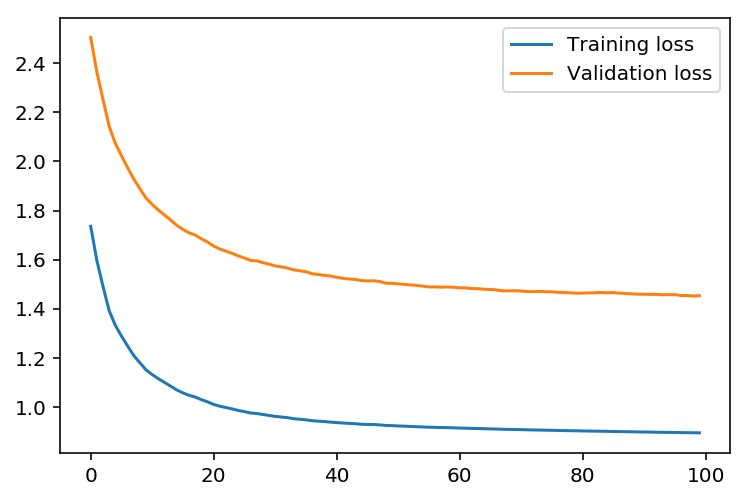

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

/Users/scrier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


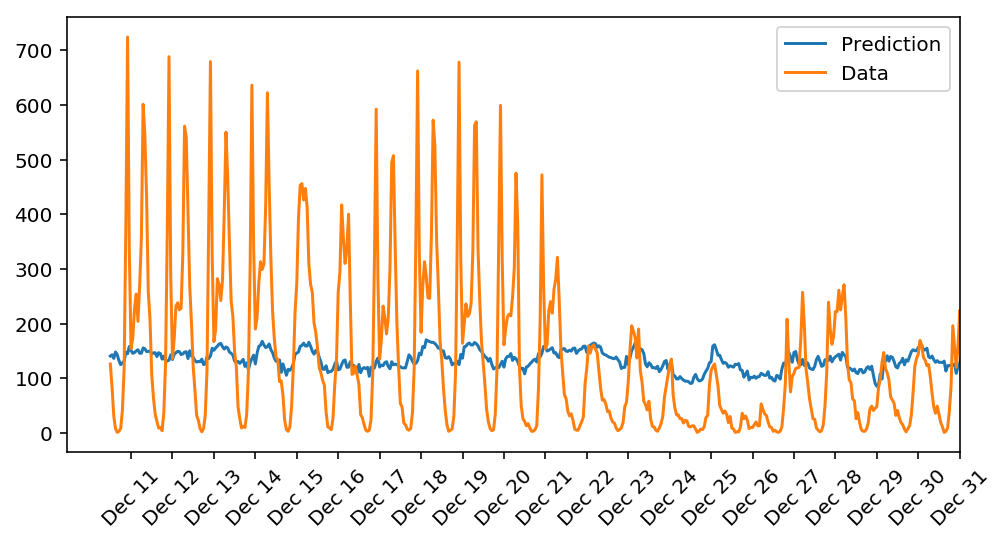

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below